In [84]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from astroML.classification import GMMBayes
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, make_scorer

In [67]:
df=pd.read_csv('galaxyquasar.csv')

In [3]:
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [77]:
#u-g, g-r, r-i, i-z

df['ug']=df['u']-df['g'] #0
df['gr']=df['g']-df['r'] #1
df['ri']=df['r']-df['i'] #2
df['iz']=df['i']-df['z'] #3

label_map = {'GALAXY': 0, 'QSO': 1}
df['class_label'] = df['class'].map(label_map).to_numpy()

galaxy = df[df['class_label'] == 0]
qso = df[df['class_label'] == 1]

features = ['ug', 'gr', 'ri', 'iz']

In [78]:
galaxy.shape

(42866, 13)

In [79]:
qso.shape

(7134, 13)

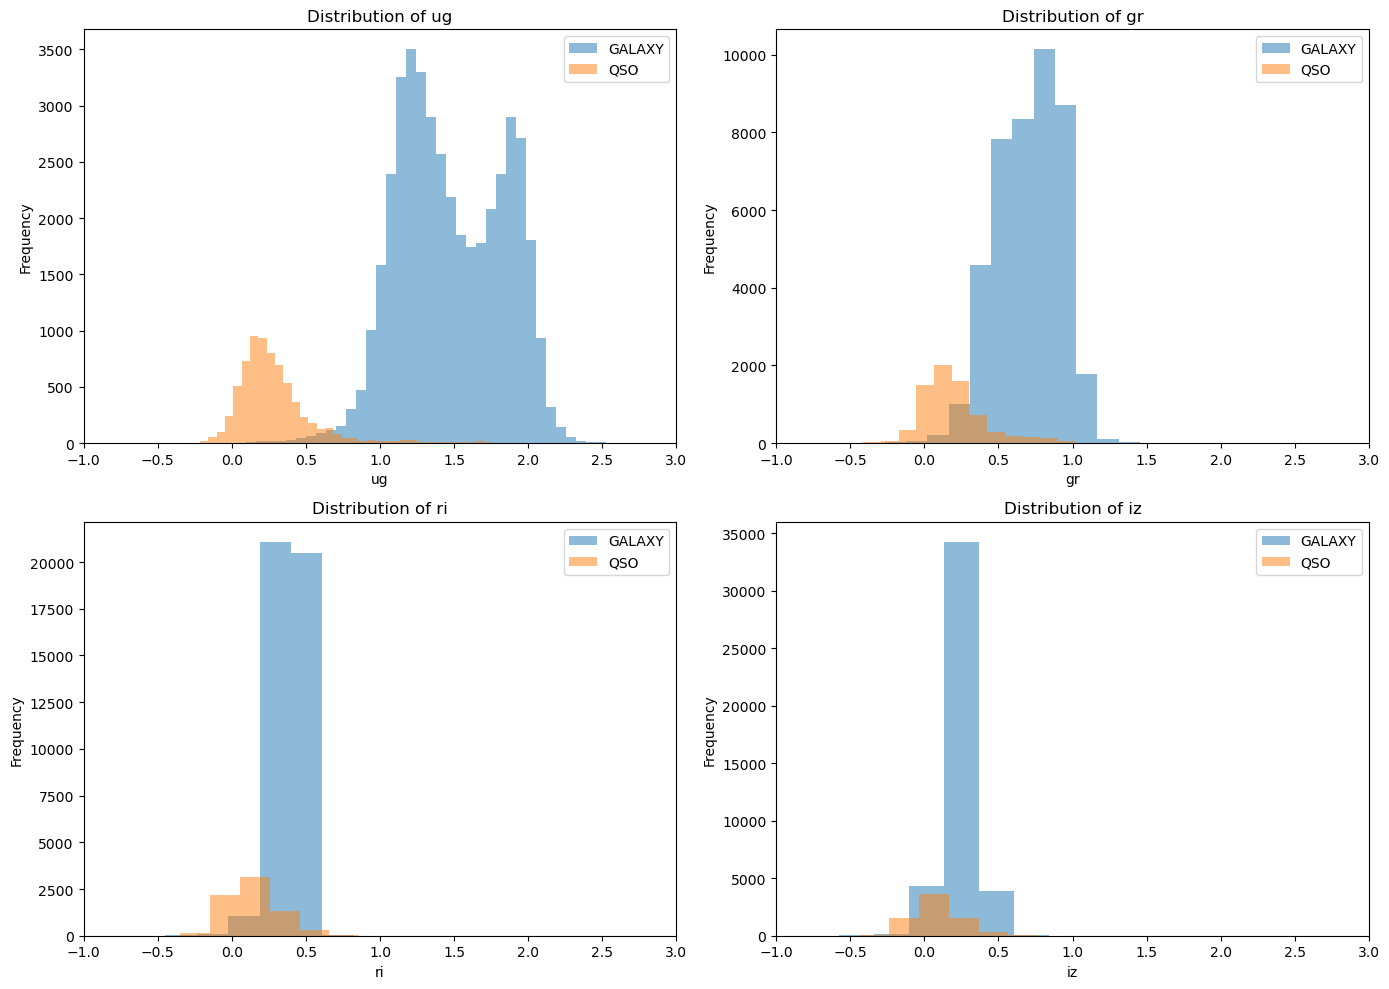

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, feature in enumerate(features):
    ax = axs[i // 2, i % 2]
    ax.hist(galaxy[feature], bins=100, alpha=0.5, label='GALAXY')
    ax.hist(qso[feature], bins=100, alpha=0.5, label='QSO')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_xlim(-1,3)
    ax.legend()

plt.tight_layout()

In [13]:
#Classify the dataset against the target label.
X = df[features].values
Y = df['class_label'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

***K-Nearest Neighbors***

In [37]:
param_grid = {
    'n_neighbors': list(range(1, 15, 2)) # to avoid ties when voting for the majority class, I put only odd numbers of neighbors
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters found: {'n_neighbors': 7}


In [38]:
knn = KNeighborsClassifier(n_neighbors=7)

In [39]:
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

In [40]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

Test set accuracy: 0.99
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8572
           1       0.96      0.94      0.95      1428

    accuracy                           0.99     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.99      0.99      0.99     10000



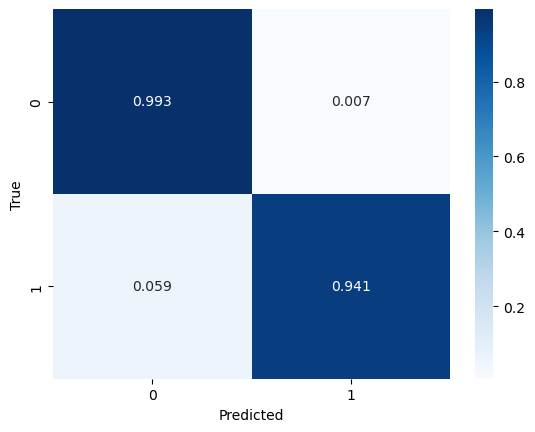

In [41]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [42]:
mean_scores_val= grid_search.cv_results_['mean_test_score']

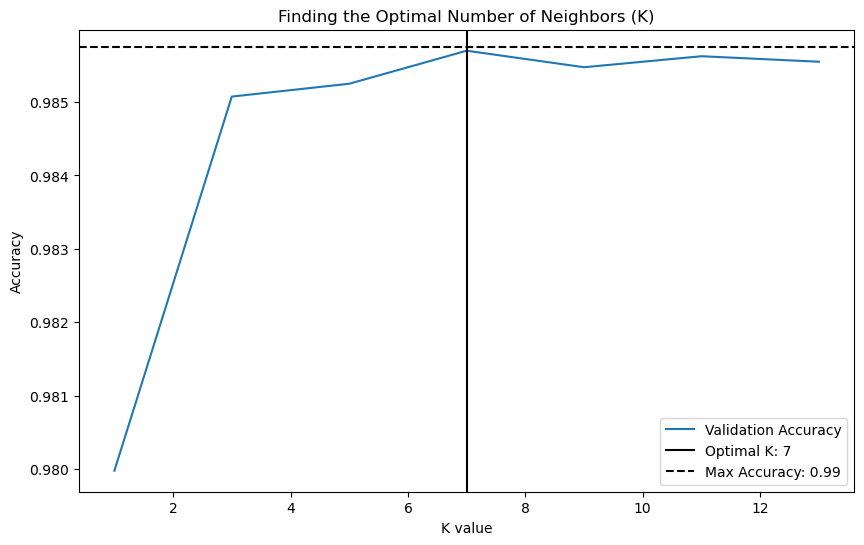

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, 15, 2)), mean_scores_val, label='Validation Accuracy')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('Finding the Optimal Number of Neighbors (K)')

# Highlight the best k value
optimal_k = grid_search.best_params_['n_neighbors']
plt.axvline(optimal_k, c='black', label=f'Optimal K: {optimal_k}')
plt.axhline(max(mean_scores), ls='--', c='black', label=f'Max Accuracy: {max(mean_scores):.2f}')
plt.legend()

***Gaussian Mixture Models***

In [51]:
unique_classes = np.unique(y_train)
n_classes = len(unique_classes)
param_grid = {
    'n_components': [np.ones(n_classes, dtype=int) * i for i in range(1, 10)]
}

gmm = GMMBayes()
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found: {'n_components': array([7, 7])}


In [52]:
mean_scores_val = grid_search.cv_results_['mean_test_score']

In [61]:
gmm = GMMBayes(n_components=7)
gmm.fit(x_train, y_train)

y_pred = gmm.predict(x_test)

In [62]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

Test set accuracy: 0.98
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8572
           1       0.95      0.93      0.94      1428

    accuracy                           0.98     10000
   macro avg       0.97      0.96      0.97     10000
weighted avg       0.98      0.98      0.98     10000



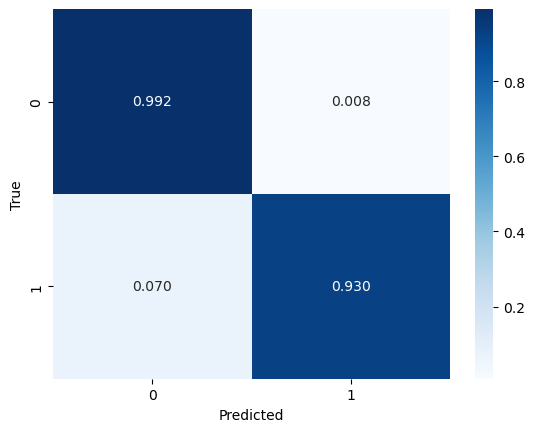

In [63]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

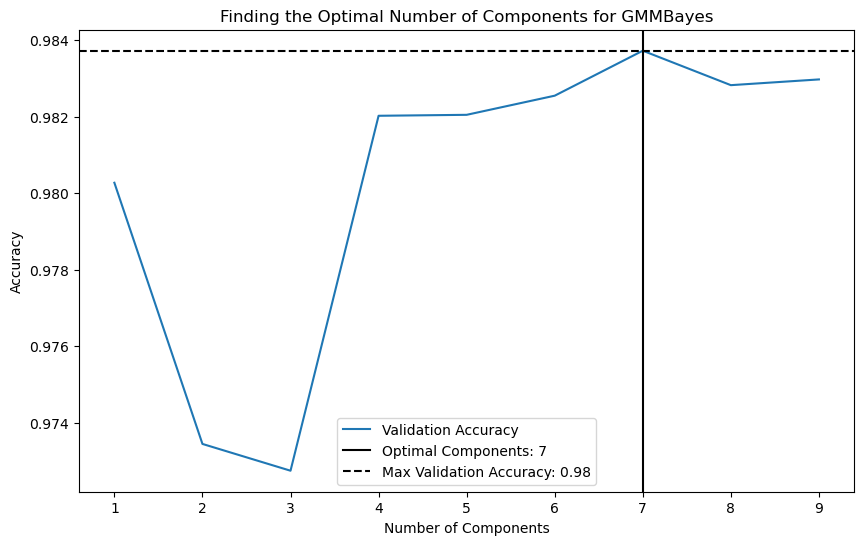

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, 10)), mean_scores_val, label='Validation Accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Finding the Optimal Number of Components for GMMBayes')

# Highlight the best n value
best_n_components = grid_search.best_params_['n_components']
optimal_n = best_n_components[0]
plt.axvline(optimal_n, c='black', label=f'Optimal Components: {optimal_n}')
plt.axhline(max(mean_scores_val), ls='--', c='black', label=f'Max Validation Accuracy: {max(mean_scores_val):.2f}')
plt.legend()
plt.show()


Let's compare some methods:

accuracy Gaussian Naive Bayes:  0.973025
completeness Gaussian Naive Bayes:  0.9225376796354714
--------------------------------------------
accuracy KNN:  0.988025
completeness KNN:  0.9479495268138801
--------------------------------------------
accuracy GMMBayes:  0.9832
completeness GMMBayes:  0.9330529267437785
--------------------------------------------
accuracy QDA:  0.980425
completeness QDA:  0.9258675078864353
--------------------------------------------


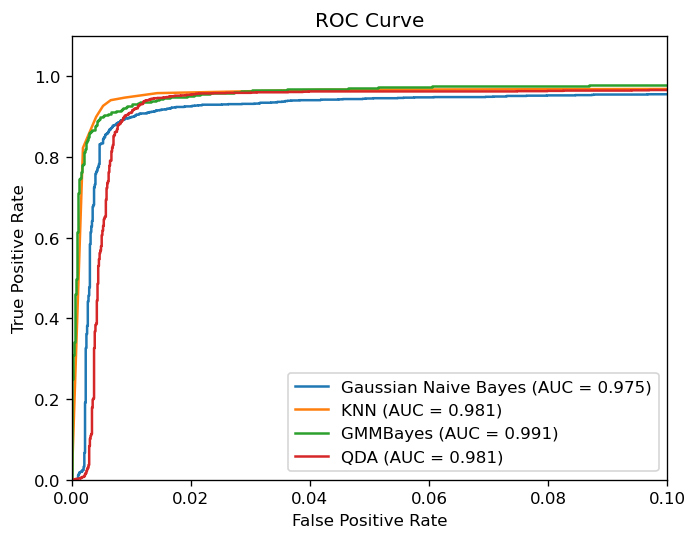

In [66]:
plt.figure(dpi=120)
names=["Gaussian Naive Bayes", "KNN", "GMMBayes", "QDA"]
models=[GaussianNB(), KNeighborsClassifier(n_neighbors=7), GMMBayes(n_components=7), QDA()]
for (name, model) in zip(names,models):
    model.fit(x_train, y_train)
    y_probs = model.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class
    y_pred = model.predict(x_train)
    score = accuracy_score(y_train, y_pred)
    print('accuracy {}: '.format(name), score)
    score1 = recall_score(y_train, y_pred)
    print('completeness {}: '.format(name), score1)
    print('--------------------------------------------')
    fpr, tpr, _ = roc_curve(y_valid, y_probs)
    roc_auc = auc(fpr, tpr)
    #auc is area under the curve, more is better
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')


plt.xlim(0.0, 0.1)
plt.ylim(0.0, 1.1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

***Feature importance***: I use the technique of permutation importance.  It works by measuring the change in the model's performance when the values of a feature are randomly shuffled. This shuffling breaks the relationship between the feature and the target variable, allowing us to see how much the model relies on that feature to make accurate predictions. The importance of the feature is determined by the decrease in the performance metric when the feature is permuted compared to the baseline performance (accuracy, f1-score ecc) chosen for the problem. For this dataset, as it's very imbalanced, I prefer to use f1-score (an harmonic mean of precision and recall) for feature importance evaluation.

Permutation importance for GMM Bayes:
ug: 0.2104
gr: 0.0840
iz: 0.0252
ri: 0.0081


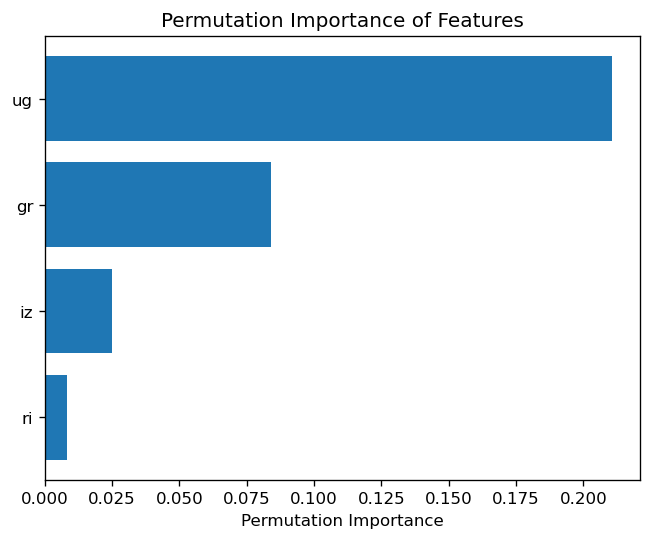

In [74]:
scoring = make_scorer(f1_score, average='weighted') # weighted average of the metric values for each class, weighted by the number of true instances in each class.
perm_importance = permutation_importance(gmm, x_test, y_test, n_repeats=10, n_jobs=-1, random_state=42, scoring=scoring)
sorted_idx = perm_importance.importances_mean.argsort()

print("Permutation importance for GMM Bayes:")
for i in sorted_idx[::-1]:
    print(f"{features[i]}: {perm_importance.importances_mean[i]:.4f}")

plt.figure(dpi=120)
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.show()